In [1]:
import torch
from torch import nn
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.svm import SVC
from copy import deepcopy

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

## Helper Function

In [6]:
def plot_histogram(data, bins=40):
    # Create the histogram
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram with Statistics')

    # Show the plot
    plt.show()

## Data Generator

In [7]:
def generate_points(num=40000,dim=18,type='normal',normal_var=1,radius=1):
    '''
    If type=='normal', then generate points from N(0,normal_var)
    If type=='spherical', then simply divide the points by their norm.'''
    X = torch.randn([num,dim]) #coordinates sampled from N(0,1)

    if type=='spherical':
      norm = torch.norm(X, p=2, dim=1, keepdim=True)
      X_spherical = X / norm
      return X_spherical

    else:
      return X


class TreeNode:
    '''
    This class represents a node in the decision tree.
    Each node has a depth, a maximum depth(of the tree), a feature index, and left and right child nodes.
    Leaf nodes have a value, which is the predicted class.
    '''
    def __init__(self, depth, max_depth, feature_index):
        self.depth = depth
        self.max_depth = max_depth
        self.feature = feature_index
        self.left = None
        self.right = None
        self.value = None  # This will store the predicted class for leaf nodes

    def build_tree(self):
        if self.depth == self.max_depth:
            self.value = float(self.feature % 2)
            return

        # Create left and right child nodes
        self.left = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+1)
        self.right = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+2)

        # Recursively build left and right subtrees
        self.left.build_tree()
        self.right.build_tree()

    def predict(self, x):
        if self.value is not None:
            return self.value

        if x[self.feature] > 0:
            return self.left.predict(x)
        else:
            return self.right.predict(x)


def gen_spherical_data(depth, dim_in, type_data, num_points, feat_index_start=0,radius=1):
    '''
    Generate points uniformly random from a hypersphere. And the label is the prediction of the tree with depth = max_depth.
    The node hyperplanes are simply characterised by standard basis vectors(for example, the root node hyperplane is x[0] = 0)

    '''
    Tree = TreeNode(depth = 0,max_depth=depth,feature_index = feat_index_start)
    Tree.build_tree()
    X = generate_points(num=num_points,dim=dim_in,type=type_data,radius=radius)

    Y=[]
    for item in X:
        Y.append(Tree.predict(item))

    Y = torch.tensor(Y)
    return X,Y
# depth = 4
# dim_in = 18
# type_data = 'normal'
# feat_index_start = 0 #the index of the first feature in the tree
# num_points = 40000


#     Tree = TreeNode(depth = 0,max_depth=depth,feature_index = feat_index_start)
#     Tree.build_tree()
#     X = generate_points(num=num_points,dim=dim_in,type=type_data)

#     Y=[]
#     for item in X:
#     Y.append(Tree.predict(item))

#     Y = torch.tensor(Y)


In [8]:
class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample_x = self.x[idx]
        sample_y = self.y[idx]

        if self.transform:
            sample_x, sample_y = self.transform(sample_x, sample_y)

        return sample_x, sample_y

## Model

In [9]:
class DLGN(nn.Module):
    def __init__(self, dim_in, width, depth, beta,bias_fn=True,bias_vn=False,const_init=False):
        super().__init__()
        self.depth = depth
        self.width = width
        self.beta = beta
        self.gates = nn.ModuleList([nn.Linear(dim_in if i == 0 else width, width, bias=bias_fn) for i in range(self.depth)])
        self.weights = nn.ModuleList([nn.Linear(width, width, bias=bias_vn) for _ in range(self.depth)])
        if const_init:
          for i in range(self.depth):
            nn.init.constant_(self.weights[i].weight,1.0/width)
        self.weight_last = nn.Linear(width, 1, bias=True)
        self.dim_in = dim_in
        self.sigmoid = nn.Sigmoid()

    def ScaledSig(self,x):
        y = self.beta*x
        S = nn.Sigmoid()
        return S(y)

    def forward(self, x):
        g = x
        h = torch.ones(self.width).to(x.device)

        for i in range(self.depth):
            g = self.gates[i](g)
            h = self.ScaledSig(g) * self.weights[i](h)

        h_last = self.weight_last(h)
        return self.sigmoid(h_last)
    


class DLGN_SF(nn.Module):
    def __init__(self, dim_in, width, depth, beta,bias_fn=True,bias_vn=False):
        super().__init__()
        self.depth = depth
        self.width = width
        self.beta = beta
        self.gates = nn.ModuleList([nn.Linear(dim_in, width, bias=bias_fn) for i in range(self.depth)]) #This is the only diff between DLGN and DLGN_SF
        self.weights = nn.ModuleList([nn.Linear(width, width, bias=bias_vn) for _ in range(self.depth)])
        self.weight_last = nn.Linear(width, 1, bias=True)
        self.dim_in = dim_in
        self.sigmoid = nn.Sigmoid()

    def ScaledSig(self,x):
        y = self.beta*x
        S = nn.Sigmoid()
        return S(y)

    def forward(self, x):
        h = torch.ones(self.width).to(x.device)

        for i in range(self.depth):
            g = self.gates[i](x)   #This is the only diff between DLGN and DLGN_SF
            h = self.ScaledSig(g) * self.weights[i](h)

        h_last = self.weight_last(h)
        return self.sigmoid(h_last)


class DLGN_Kernel(nn.Module):
    def __init__(self, num_data, dim_in, width, depth, beta = 4):   #output dimension is 1
        super().__init__()
        self.num_data = num_data
        self.beta = beta
        self.dim_in = dim_in
        self.width = width
        self.depth = depth
        sigma = 1/np.sqrt(width)
        self.gates = nn.ParameterList([nn.Parameter(sigma*torch.randn(dim_in if i == 0 else width, width)) for i in range(depth)])
        self.alphas = nn.Parameter(torch.randn(num_data)/np.sqrt(num_data))
        self.sigmoid = nn.Sigmoid()
        #self._cache = None

    def ScaledSig(self,x):
        y = self.beta*x
        S = nn.Sigmoid()
        return S(y)

    def get_weights(self):
        A = [self.gates[0]]
        for i in range(1,self.depth):
            A.append(A[-1]@self.gates[i])
        return torch.vstack(A)


    def forward(self, inp, data):
        #ones = torch.ones(self.dim_in).to(x.device())
        #self._cache = None
        data_gate_matrix = data @ self.gates[0]
        data_gate_score = self.ScaledSig(data_gate_matrix)
        inp_gate_matrix = inp @ self.gates[0]
        inp_gate_score = self.ScaledSig(inp_gate_matrix)
        output_kernel =  (inp_gate_score @ data_gate_score.T)
        for i in range(1,self.depth):
            data_gate_matrix = data_gate_matrix @ self.gates[i]
            inp_gate_matrix = inp_gate_matrix @ self.gates[i]
            data_gate_score = self.ScaledSig(data_gate_matrix)
            inp_gate_score = self.ScaledSig(inp_gate_matrix)
            output_kernel *= (inp_gate_score @ data_gate_score.T)/self.width
        #print(torch.max(output_kernel), torch.min(output_kernel))
        return self.sigmoid(output_kernel @ self.alphas)


## log functions

In [10]:
def log_features_dlgn(model,bias_log=False):
  '''
  This function returns the log of the features of the gates in model.
  Returns a 2-d tensor with rows of shape (num_gates, data_dim)
  '''
  weight = []
  bias = []
  for name, param in model.named_parameters():
      for i in range(0,model.depth):
          if name == 'gates.'+str(i)+'.weight':
              weight.append(param.data)
          if bias_log:
            if name == 'gates.'+str(i)+'.bias':
                bias.append(param.data)

  Feature_list = [weight[0]]

  for w in weight[1:]:
    Feature_list.append(w @ Feature_list[-1])

  features = torch.cat(Feature_list, axis = 0)

  return features #make it to .to("cpu") if you want to use it in numpy


def log_features_dlgn_sf(model,bias_log=False):
  '''
  This function returns the log of the features of the gates in model.
  Returns a 2-d tensor with rows of shape (num_gates, data_dim)
  '''
  weight = []
  bias = []
  for name, param in model.named_parameters():
      for i in range(0,model.depth):
          if name == 'gates.'+str(i)+'.weight':
              weight.append(param.data)
          if bias_log:
            if name == 'gates.'+str(i)+'.bias':
                bias.append(param.data)

  Feature_list = []

  for w in weight:
    Feature_list.append(w)

  features = torch.cat(Feature_list, axis = 0)

  return features #make it to .to("cpu") if you want to use it in numpy

def log_features_DLGN_kernel(model,bias=False):   ## Don't use it for DLGN model
  weight = []
  bias = []
  for name, param in model.named_parameters():
      for i in range(0,model.depth):
          if name == 'gates.'+str(i):
              weight.append(param.data)
          if bias:
            if name == 'gates.'+str(i)+'.bias':
                bias.append(param.data)

  Feature_list = [weight[0].T]

  for w in weight[1:]:
    Feature_list.append(w.T @ Feature_list[-1])

  features = torch.cat(Feature_list, axis = 0)

  return features   #make it to .to("cpu") if you want to use it in numpy


def feature_stats(features,data_dim=18,tree_depth=4,dim_in=18,threshold=0.1,req_index=False): #can set tree_depth=0 to get root node stats...
  '''
  Returns the count of features that are close to the standard basis vectors within a threshold
  Can return the indices of the features as well if req_index=True
  count is a 1-d tensor of length 2**tree_depth-1
  index is a list of lists of length 2**tree_depth-1 with each list containing the indices of the
  features that are close to the standard basis vector corresponding to that node.
  '''
  num_nodes = 2**tree_depth-1
  tensor = torch.eye(data_dim)  #standard basis
  y=torch.randn(dim_in)
  rand_point=y/torch.norm(y, p=2)

  count = torch.zeros(num_nodes)
  index = [[]]*num_nodes
  for ind,item in enumerate(features):
      for i in range(num_nodes):
        if torch.linalg.vector_norm(item/(item.norm(dim=0, p=2))-tensor[i]) < threshold or torch.linalg.vector_norm(item/(item.norm(dim=0, p=2))+tensor[i]) < threshold:
            count[i] += 1
            if req_index:
              index[i].append(ind)
  if req_index:
    return count,index
  else:
    return count

## Train Function

In [11]:
def train(model,num_epochs,loss_fn,optimizer,train_dataloader,
          data,
          log_features_fn,log_epochs=10,log_weight=10,log_acc=0,thresh=0.01,print_std=False):
  [x_train,y_train,x_int,y_int,x_bound,y_bound,x_bound_root,y_bound_root,x_test,y_test]=data
  features_initial = log_features_fn(model)
  features_train=[]
  model.to(device)
  Train_losses=[]
  acc_dict = {'train':[],'test':[],'int':[],'bound':[],'bound_root':[]}
  for epoch in range(num_epochs):
      model.train()
      for x_batch, y_batch in train_dataloader:
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          pred = model(x_batch)[:, 0]
          loss = loss_fn(pred, y_batch)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()


      if epoch % log_weight == 0:
          features_train.append(log_features_fn(model))
      if epoch % log_epochs == 0:
          loss_full = loss_fn(model(x_train.to(device))[:,0],y_train.to(device))
          Train_losses.append(loss_full.item())
          if print_std:
            print(f'Epoch {epoch} Loss {loss_full.item():.4f}')
      if log_acc!=0:
        if epoch % log_acc == 0:
          train_pred = model(x_train.to(device))[:,0]
          thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
          zero_mask = (thresh_pred-y_train.to(device) == 0.0)
          train_acc = zero_mask.sum().item()/len(y_train)
          acc_dict['train'].append(train_acc)

          int_pred = model(x_int.to(device))[:,0]
          thresh_pred = torch.where(int_pred < 0.5, torch.tensor(0), torch.tensor(1))
          zero_mask = (thresh_pred-y_int.to(device) == 0.0)
          int_acc = zero_mask.sum().item()/len(y_int)
          acc_dict['int'].append(int_acc)

          bound_pred = model(x_bound.to(device))[:,0]
          thresh_pred = torch.where(bound_pred < 0.5, torch.tensor(0), torch.tensor(1))
          zero_mask = (thresh_pred-y_bound.to(device) == 0.0)
          bound_acc = zero_mask.sum().item()/len(y_bound)
          acc_dict['bound'].append(bound_acc)

          test_pred = model(x_test.to(device))[:,0]
          thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
          zero_mask = (thresh_pred-y_test.to(device) == 0.0)
          test_acc = zero_mask.sum().item()/len(y_test)
          acc_dict['test'].append(test_acc)

          bound_root_pred = model(x_bound_root.to(device))[:,0]
          thresh_pred = torch.where(bound_root_pred < 0.5, torch.tensor(0), torch.tensor(1))
          zero_mask = (thresh_pred-y_bound_root.to(device) == 0.0)
          bound_root_acc = zero_mask.sum().item()/len(y_bound_root)
          acc_dict['bound_root'].append(bound_root_acc)
          if print_std:
            print(f'Epoch {epoch} train_acc {train_acc} test_acc {test_acc}  // interior {int_acc} boundary {bound_acc} root_node {bound_root_acc}')
      if loss_full.item() < thresh:
          print(f'Early stopping at epoch {epoch} because loss is below 0.01')
          break

  features_final = log_features_fn(model)
  return Train_losses,features_train,acc_dict

## Data

In [12]:
dim_in = 18
tree_depth = 4
num_points = 30000

In [13]:
X,Y = gen_spherical_data(depth=tree_depth, dim_in=dim_in, type_data='spherical', num_points=num_points, feat_index_start=0,radius=1)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42, stratify=Y
)

In [15]:
# Create DataLoaders for train and test datasets
batch_size = 32

# Assuming you have a custom Dataset class, you can create instances like this:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Separation

In [16]:
bound_list_root=[]
bound_thresh_root=0.01
num_nodes = 2**tree_depth-1

In [17]:
for i in range(len(x_train)):
  if (torch.abs(x_train[i][0])<bound_thresh_root).any():  #if the first coordinate is less than the threshold
    bound_list_root.append(i) #then it is a boundary point

In [18]:
# full =list(range(int(0.9*num_points)))
# int_list = [x for x in full if x not in bound_list] #interior points are those that are not boundary points

In [19]:
# x_int = x_train[int_list]
# y_int = y_train[int_list]
x_bound_root = x_train[bound_list_root]
y_bound_root = y_train[bound_list_root]

In [17]:
len(bound_list_root)

820

## KNN

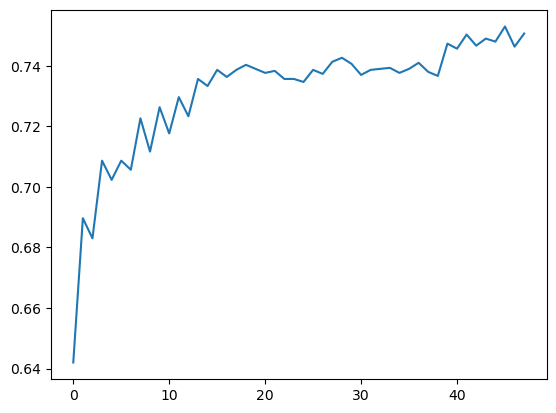

In [18]:
# Create a Nearest Neighbors classifier with k
acc_list = []
for i in range(2,50):
  knn = KNeighborsClassifier(n_neighbors=i)

  # Fit the classifier to the training data
  knn.fit(x_train, y_train)

  # Predict the classes of the test set
  y_pred = knn.predict(x_test)

  # Calculate the accuracy of the classifier
  acc_list.append(accuracy_score(y_test, y_pred))
# print("Accuracy:", accuracy)
plt.plot(acc_list)

In [20]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(x_train,y_train)
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_10.fit(x_train,y_train)
knn_20 = KNeighborsClassifier(n_neighbors=20)
knn_20.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=20)

In [21]:
y_pred = torch.tensor(knn_5.predict(x_train))
comp_5 = (y_pred == y_train).int()
comp_5

tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)

In [22]:
y_pred = torch.tensor(knn_10.predict(x_train))
comp_10 = (y_pred == y_train).int()
comp_10

tensor([1, 1, 1,  ..., 0, 1, 1], dtype=torch.int32)

In [23]:
y_pred = torch.tensor(knn_20.predict(x_train))
comp_20 = (y_pred == y_train).int()
comp_20

tensor([1, 1, 1,  ..., 0, 1, 1], dtype=torch.int32)

In [24]:
int_points = torch.flatten(torch.nonzero(comp_5*comp_10*comp_20)) #intersection of the 3 sets (the points that are easy to classifyby k-NN)

In [25]:
full =list(range(int(len(x_train))))
bound = [x for x in full if x not in int_points]

In [26]:
x_int = x_train[int_points]
y_int = y_train[int_points]
x_bound = x_train[bound]
y_bound = y_train[bound]

In [27]:
len(x_bound),len(x_int)

(9073, 17927)

In [27]:
common_elements = set(bound) & set(bound_list_root) # find the common elements between the boundary points and the root node boundary points
num_common_elements = len(common_elements)
print(num_common_elements/len(bound_list_root))

0.3975609756097561


In [38]:
boundl=[]

In [40]:
for i in range(len(x_int)):
  if (torch.abs(x_int[i][:num_nodes])<bound_thresh_root).any():  #if any of the first num_nodes features are close to 0
    boundl.append(i) #then it is a boundary point

In [41]:
len(boundl)

6945

## Std Training procedure

In [33]:
model = DLGN(dim_in=dim_in,width = 500,depth = 4,beta=5)
loss_fn = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [31]:
log_epochs = 10
num_epochs = 250
log_weight = 10

In [34]:
tl,fi,ft,fl=train(model,num_epochs,loss_fn,optimizer,train_dataloader,log_features_dlgn,log_epochs,log_weight,log_acc = log_epochs,thresh=0.01)

Epoch 0 Loss 0.6931
Epoch 0 train_acc 0.5005925925925926 test_acc 0.5006666666666667  // interior 0.5369395333370283 boundary 0.4273752372446131 root_node 0.5257270693512305
Epoch 10 Loss 0.6657
Epoch 10 train_acc 0.6169629629629629 test_acc 0.6083333333333333  // interior 0.7116887435570581 boundary 0.426147147482416 root_node 0.6319910514541387
Epoch 20 Loss 0.6442
Epoch 20 train_acc 0.6227407407407407 test_acc 0.6156666666666667  // interior 0.7181732527850135 boundary 0.43050128391202414 root_node 0.6297539149888143
Epoch 30 Loss 0.6141
Epoch 30 train_acc 0.6587037037037037 test_acc 0.662  // interior 0.7727650612425871 boundary 0.42893826057831863 root_node 0.6543624161073825
Epoch 40 Loss 0.5452
Epoch 40 train_acc 0.7176296296296296 test_acc 0.711  // interior 0.8347281494208281 boundary 0.4817461203527967 root_node 0.6823266219239373
Epoch 50 Loss 0.4512
Epoch 50 train_acc 0.7837407407407407 test_acc 0.772  // interior 0.8819486781577343 boundary 0.5859104610918835 root_node 0.7

In [42]:
test_loss_full = loss_fn(model(x_test.to(device))[:,0],y_test.to(device))
print(test_loss_full)

tensor(0.2084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [43]:
train_pred = model(x_train.to(device))[:,0]
thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_train.to(device) == 0.0)

# Count the number of zeros
train_acc = zero_mask.sum().item()/len(y_train)
train_acc

1.0

In [44]:
test_pred = model(x_test.to(device))[:,0]
thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_test.to(device) == 0.0)

# Count the number of zeros
test_acc = zero_mask.sum().item()/len(y_test)
test_acc

0.9503333333333334

In [45]:
features_initial=fi
features_train = ft
features_final = fl

In [46]:
# print(feature_stats(features_initial.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
epoch=0
for f in features_train:
  print(epoch)
  print(feature_stats(f.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
  epoch+=10
print(epoch)
# print(feature_stats(features_final.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))

0
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
10
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
20
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
30
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
40
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
50
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
60
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
70
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
80
tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
90
tensor([7., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.])
100
tensor([11.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         0.])
110
tensor([13.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.])
120
tensor([11.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
       

In [ ]:
model_copy = deepcopy(model)

## Gated Network

In [ ]:
for param in model_copy.gates.parameters():
  print(param)

Parameter containing:
tensor([[-0.2456,  0.1244,  0.3674,  ..., -0.2832,  0.0106, -0.2207],
        [ 0.1066,  0.2120,  0.3287,  ..., -0.0680,  0.1411, -0.0906],
        [-0.3182,  0.0994, -0.2159,  ...,  0.0214,  0.2714,  0.0436],
        ...,
        [-0.0816,  0.1739, -0.0454,  ...,  0.1226, -0.1879, -0.1784],
        [-0.2658,  0.0670, -0.0695,  ..., -0.0803, -0.1796,  0.1754],
        [-0.4057, -0.3806,  0.3134,  ...,  0.0298,  0.1448, -0.0416]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0097,  0.0752, -0.0005,  ...,  0.0505,  0.0740, -0.0378],
        [ 0.0550,  0.0091, -0.1024,  ..., -0.0190, -0.0755,  0.0070],
        [-0.0003, -0.0866,  0.0143,  ..., -0.0525, -0.0262,  0.0556],
        ...,
        [-0.0370,  0.0395, -0.0422,  ..., -0.0222,  0.0695, -0.0290],
        [-0.0620, -0.0485, -0.0212,  ..., -0.0146, -0.0733,  0.0495],
        [-0.0438, -0.0563,  0.0306,  ..., -0.0287, -0.0407,  0.0063]],
       device='cuda:0', requires_grad=True)


In [ ]:
model_GN=DLGN(dim_in=dim_in,width = 200,depth = 3,beta=5, bias_fn=False)

Replace the gate weights with that of trained network and freeze 'em

In [ ]:
for i in range(len(model_GN.gates)):
  model_GN.gates[i] = deepcopy(model_copy.gates[i])
  model_GN.gates[i].requires_grad_(False)

In [ ]:
loss_fn = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_GN.parameters(), lr = learning_rate)

In [ ]:
log_epochs = 10
num_epochs = 500
log_weight = 10

In [ ]:
train(model_GN,num_epochs,loss_fn,optimizer,train_dataloader,log_features_dlgn,log_epochs,log_weight,thresh=0.01)

In [ ]:
test_loss_full = loss_fn(model_GN(x_test.to(device))[:,0],y_test.to(device))
print(test_loss_full)

tensor(0.1729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
train_pred = model_GN(x_train.to(device))[:,0]
thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_train.to(device) == 0.0)

# Count the number of zeros
train_acc = zero_mask.sum().item()/len(y_train)
train_acc

0.9997777777777778

In [ ]:
test_pred = model_GN(x_test.to(device))[:,0]
thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_test.to(device) == 0.0)

# Count the number of zeros
test_acc = zero_mask.sum().item()/len(y_test)
test_acc

0.968

In [ ]:
model_RGN=DLGN(dim_in=dim_in,width = 200,depth = 3,beta=5, bias_fn=False)

 Freezing Gates

In [ ]:
for i in range(len(model_RGN.gates)):
  model_RGN.gates[i].requires_grad_(False)

In [ ]:
loss_fn = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_RGN.parameters(), lr = learning_rate)

In [ ]:
log_epochs = 10
num_epochs = 500
log_weight = 10

In [ ]:
train(model_RGN,num_epochs,loss_fn,optimizer,train_dataloader,log_features_dlgn,log_epochs,log_weight,thresh=0.01)

In [ ]:
test_loss_full = loss_fn(model_RGN(x_test.to(device))[:,0],y_test.to(device))
print(test_loss_full)

tensor(0.3517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
train_pred = model_RGN(x_train.to(device))[:,0]
thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_train.to(device) == 0.0)

# Count the number of zeros
train_acc = zero_mask.sum().item()/len(y_train)
train_acc

0.8535555555555555

In [ ]:
test_pred = model_RGN(x_test.to(device))[:,0]
thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_test.to(device) == 0.0)

# Count the number of zeros
test_acc = zero_mask.sum().item()/len(y_test)
test_acc

0.847

## Freeze Value network

### Random Net

In [47]:
model_RVN=DLGN(dim_in=dim_in,width = 200,depth = 4,beta=20, bias_fn=False)

Freezing the value network(not freezing the last VN layer though)




In [48]:
for i in range(len(model_RVN.weights)):
  model_RVN.weights[i].requires_grad_(False)
#model_RVN.weight_last.requires_grad_(False)

In [49]:
loss_fn = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_RVN.parameters(), lr = learning_rate)

In [50]:
log_epochs = 10
num_epochs = 500
log_weight = 10

In [52]:
tl,fi,ft,fl=train(model_RVN,num_epochs,loss_fn,optimizer,train_dataloader,log_features_dlgn,log_epochs,log_weight,log_acc = log_epochs,thresh=0.01)

Epoch 0 Loss 0.6486
Epoch 0 train_acc 0.6238518518518519 test_acc 0.6136666666666667  // interior 0.7177298675386576 boundary 0.43474377581779616 root_node 0.6297539149888143
Epoch 10 Loss 0.6396
Epoch 10 train_acc 0.6295185185185185 test_acc 0.6213333333333333  // interior 0.7266529956215707 boundary 0.4338506196271073 root_node 0.6308724832214765
Epoch 20 Loss 0.6279
Epoch 20 train_acc 0.6447777777777778 test_acc 0.6356666666666667  // interior 0.7493210663415175 boundary 0.4341855531986156 root_node 0.6409395973154363
Epoch 30 Loss 0.6114
Epoch 30 train_acc 0.6662222222222223 test_acc 0.658  // interior 0.7757579116554897 boundary 0.4455732946298984 root_node 0.6364653243847874
Epoch 40 Loss 0.5918
Epoch 40 train_acc 0.6871481481481482 test_acc 0.6716666666666666  // interior 0.8001995233608602 boundary 0.4594172155855755 root_node 0.6498881431767338
Epoch 50 Loss 0.5695
Epoch 50 train_acc 0.7104814814814815 test_acc 0.6946666666666667  // interior 0.8218145541207116 boundary 0.4862

In [53]:
test_loss_full = loss_fn(model_RVN(x_test.to(device))[:,0],y_test.to(device))
print(test_loss_full)

tensor(0.2420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [54]:
train_pred = model_RVN(x_train.to(device))[:,0]
thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_train.to(device) == 0.0)

# Count the number of zeros
train_acc = zero_mask.sum().item()/len(y_train)
train_acc

0.9747407407407407

In [55]:
test_pred = model_RVN(x_test.to(device))[:,0]
thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_test.to(device) == 0.0)

# Count the number of zeros
test_acc = zero_mask.sum().item()/len(y_test)
test_acc

0.9016666666666666

In [56]:
epoch=0
for f in ft:
  print(epoch)
  print(feature_stats(f.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
  epoch+=10

0
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
10
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
20
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
30
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
40
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
50
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
60
tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
70
tensor([9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
80
tensor([17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.])
90
tensor([20.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.])
100
tensor([25.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.])
110
tensor([28.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.])
120
tensor([31.,  0.,  5.,  0.,  0.,  0.,  

### Inherited

In [ ]:
model_VN=DLGN(dim_in=dim_in,width = 200,depth = 3,beta=10, bias_fn=False)

inheriting the weights and freezing the value network(not freezing the last weight anyway)




In [ ]:
for i in range(len(model_VN.weights)):
  model_VN.weights[i] = deepcopy(model_copy.weights[i])
  model_VN.weights[i].requires_grad_(False)
#model_RVN.weight_last.requires_grad_(False)

In [ ]:
loss_fn = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_VN.parameters(), lr = learning_rate)

In [ ]:
log_epochs = 10
num_epochs = 500
log_weight = 10

In [ ]:
tl1,fi1,ft1,fl1=train(model_VN,num_epochs,loss_fn,optimizer,train_dataloader,log_features_dlgn,log_epochs,log_weight,thresh=0.01)

Epoch 0 Loss 0.5781
Epoch 10 Loss 0.2611
Epoch 20 Loss 0.1716
Epoch 30 Loss 0.1209
Epoch 40 Loss 0.0850
Epoch 50 Loss 0.0745
Epoch 60 Loss 0.0566
Epoch 70 Loss 0.0571
Epoch 80 Loss 0.0381
Epoch 90 Loss 0.0340
Epoch 100 Loss 0.1034
Epoch 110 Loss 0.0190
Epoch 120 Loss 0.0175
Epoch 130 Loss 0.0103
Epoch 140 Loss 0.0074
Early stopping at epoch 140 because loss is below 0.01


In [ ]:
test_loss_full = loss_fn(model_VN(x_test.to(device))[:,0],y_test.to(device))
print(test_loss_full)

tensor(0.1251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
train_pred = model_VN(x_train.to(device))[:,0]
thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_train.to(device) == 0.0)

# Count the number of zeros
train_acc = zero_mask.sum().item()/len(y_train)
train_acc

0.9993333333333333

In [ ]:
test_pred = model_VN(x_test.to(device))[:,0]
thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_test.to(device) == 0.0)

# Count the number of zeros
test_acc = zero_mask.sum().item()/len(y_test)
test_acc

0.961

## DLGN_SF

In [27]:
model = DLGN_SF(dim_in=dim_in,width = 500,depth = 4,beta=5)
loss_fn = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD([
                {'params': model.gates[0].parameters(),'lr': 1e-4},
                {'params': model.gates[1].parameters(),'lr': (200**(0.5))*1e-4},
                {'params': model.gates[2].parameters(),'lr': (200**(1))*1e-4},
                {'params': model.gates[3].parameters(),'lr': (200**(1.5))*1e-4},
                {'params': model.weights[0].parameters(),'lr': learning_rate},
                {'params': model.weights[1].parameters(),'lr': learning_rate},
                {'params': model.weights[2].parameters(),'lr': learning_rate},
                {'params': model.weight_last.parameters(),'lr': learning_rate}
            ])

In [28]:
log_epochs = 10
num_epochs = 250
log_weight = 10

In [29]:
tl,fi,ft,fl=train(model,num_epochs,loss_fn,optimizer,train_dataloader,log_features_dlgn_sf,log_epochs,log_weight,log_acc = log_epochs,thresh=0.01)

Epoch 0 Loss 0.6910
Epoch 0 train_acc 0.6149259259259259 test_acc 0.6213333333333333  // interior 0.7145071124149001 boundary 0.41352289264524794 root_node 0.6018518518518519
Epoch 10 Loss 0.4631
Epoch 10 train_acc 0.7773333333333333 test_acc 0.7586666666666667  // interior 0.8813306027564067 boundary 0.566998768610769 root_node 0.7094907407407407
Epoch 20 Loss 0.3480
Epoch 20 train_acc 0.8414074074074074 test_acc 0.805  // interior 0.9268832678363867 boundary 0.6685324079256688 root_node 0.7604166666666666
Epoch 30 Loss 0.2520
Epoch 30 train_acc 0.8937777777777778 test_acc 0.8413333333333334  // interior 0.9402225051198317 boundary 0.7998432777342438 root_node 0.8275462962962963
Epoch 40 Loss 0.2050
Epoch 40 train_acc 0.9174444444444444 test_acc 0.8516666666666667  // interior 0.9573808601317318 boundary 0.8366730101869473 root_node 0.84375
Epoch 50 Loss 0.2138
Epoch 50 train_acc 0.910962962962963 test_acc 0.8453333333333334  // interior 0.9423811368793934 boundary 0.8474196798388 roo

In [ ]:
test_loss_full = loss_fn(model(x_test.to(device))[:,0],y_test.to(device))
print(test_loss_full)

In [ ]:
train_pred = model(x_train.to(device))[:,0]
thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_train.to(device) == 0.0)

# Count the number of zeros
train_acc = zero_mask.sum().item()/len(y_train)
train_acc

In [ ]:
test_pred = model(x_test.to(device))[:,0]
thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_test.to(device) == 0.0)

# Count the number of zeros
test_acc = zero_mask.sum().item()/len(y_test)
test_acc

0.9503333333333334

In [78]:
features_initial=fi
features_train = ft
features_final = fl

In [79]:
# print(feature_stats(features_initial.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
epoch=0
for f in features_train:
  print(epoch)
  print(feature_stats(f.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
  epoch+=10
print(epoch)
# print(feature_stats(features_final.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))

0


tensor([2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 1., 1., 0.])
10


In [ ]:
plot_histogram(model.weight_last.weight.cpu().detach().numpy().flatten())

## Alternating fl and reg

In [ ]:
model_alt = DLGN(dim_in=dim_in,width = 200,depth = 3,beta=5, bias_fn=False)
loss_fn = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_alt.parameters(), lr = learning_rate)

In [ ]:
log_epochs = 5
num_epochs = 500
log_weight = 5

In [ ]:
features_initial = log_features_dlgn(model_alt)
features_train=[]

In [ ]:
FN = False
# VN_epochs = 20
# FN_epochs = 10

In [ ]:
model_alt.to(device)
Train_losses=[]
for epoch in range(num_epochs):
    model_alt.train()
    if epoch%5 ==0 :
      if FN:
          print('Feature Net')
      else:
          print('Value Net')
      if epoch !=0:
        FN = not(FN)
      if FN:
        for param in model_alt.gates.parameters():
          param.requires_grad = True
        for param in model_alt.weights.parameters():
          param.requires_grad = False
        for param in model_alt.weight_last.parameters():
          param.requires_grad = False
      else:
        for param in model_alt.gates.parameters():
          param.requires_grad = False
        for param in model_alt.weights.parameters():
          param.requires_grad = True
        for param in model_alt.weight_last.parameters():
          param.requires_grad = True

    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model_alt(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    if epoch % log_weight == 4:
        features_train.append(log_features_dlgn(model_alt))
    if epoch % log_epochs ==4:
        loss_full = loss_fn(model_alt(x_train.to(device))[:,0],y_train.to(device))
        Train_losses.append(loss_full.item())

        print(f'Epoch {epoch} Loss {loss_full.item():.4f}')

        if loss_full.item() < 0.01:
            print(f'Early stopping at epoch {epoch} because loss is below 0.01')
            break

features_final = log_features_dlgn(model_alt)

Value Net
Epoch 4 Loss 0.6898
Value Net
Epoch 9 Loss 0.6891
Feature Net
Epoch 14 Loss 0.6704
Value Net
Epoch 19 Loss 0.6621
Feature Net
Epoch 24 Loss 0.6068
Value Net
Epoch 29 Loss 0.6023
Feature Net
Epoch 34 Loss 0.6004
Value Net
Epoch 39 Loss 0.5982
Feature Net
Epoch 44 Loss 0.5960
Value Net
Epoch 49 Loss 0.5918
Feature Net
Epoch 54 Loss 0.5843
Value Net
Epoch 59 Loss 0.5742
Feature Net
Epoch 64 Loss 0.5510
Value Net
Epoch 69 Loss 0.5260
Feature Net
Epoch 74 Loss 0.4920
Value Net
Epoch 79 Loss 0.4633
Feature Net
Epoch 84 Loss 0.4274
Value Net
Epoch 89 Loss 0.3857
Feature Net
Epoch 94 Loss 0.3801
Value Net
Epoch 99 Loss 0.3113
Feature Net
Epoch 104 Loss 0.2877
Value Net
Epoch 109 Loss 0.2559
Feature Net
Epoch 114 Loss 0.2391
Value Net
Epoch 119 Loss 0.2210
Feature Net
Epoch 124 Loss 0.2819
Value Net
Epoch 129 Loss 0.1931
Feature Net
Epoch 134 Loss 0.2173
Value Net
Epoch 139 Loss 0.1649
Feature Net
Epoch 144 Loss 0.1664
Value Net
Epoch 149 Loss 0.1409
Feature Net
Epoch 154 Loss 0.1413


In [ ]:
test_loss_full = loss_fn(model_alt(x_test.to(device))[:,0],y_test.to(device))
print(test_loss_full)

tensor(0.1297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
train_pred = model_alt(x_train.to(device))[:,0]
thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_train.to(device) == 0.0)

# Count the number of zeros
train_acc = zero_mask.sum().item()/len(y_train)
train_acc

0.9993333333333333

In [ ]:
test_pred = model_alt(x_test.to(device))[:,0]
thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_test.to(device) == 0.0)

# Count the number of zeros
test_acc = zero_mask.sum().item()/len(y_test)
test_acc

0.966

## DLGN Kernel

### Centers

In [79]:
#generating centers
inp_x, data_x, inp_y, data_y = train_test_split(
   x_train, y_train, test_size=0.2, random_state=426955834
)

### Training

In [80]:
model = DLGN_Kernel(len(data_x), dim_in=dim_in,width = 100,depth = 4,beta=10)
loss_fn = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD([param for param in model.gates] + [model.alphas], lr = learning_rate)

In [81]:
log_epochs = 20
num_epochs = 1500
log_weight = 20
log_acc = log_epochs

In [82]:
features_initial = log_features_DLGN_kernel(model)
features_train=[]

In [84]:
flag = False

In [85]:
model.to(device)
data_x = data_x.to(device)
Train_losses=[]
for epoch in range(num_epochs):
    model.train()
    if epoch%20 ==0 :
      if epoch%20 ==0:    ## alternating every 20 epochs can we do better??
        flag = not(flag)
      if flag:
          print('Alphas')
      else:
          print('Gates')
      if flag:
        for param in model.gates:
          param.requires_grad = True
          #print(param)
        model.alphas.requires_grad = False
        #print(model.alphas)
      else:
        for param in model.gates:
          param.requires_grad = False
          #print(param)
        model.alphas.requires_grad = True
        #print(model.alphas)

    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch,data_x)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    if epoch % log_weight == 0:
        features_train.append(log_features_DLGN_kernel(model))
    if epoch % log_epochs == 0:
        loss_full = loss_fn(model(X.to(device), data_x),Y.to(device))
        Train_losses.append(loss_full.item())

        print(f'Epoch {epoch} Loss {loss_full.item():.4f}')

        if loss_full.item() < 0.01:
            print(f'Early stopping at epoch {epoch} because loss is below 0.01')
            break
    if log_acc!=0:
      if epoch % log_acc == 0:
        train_pred = model(x_train.to(device),data_x)
        thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
        zero_mask = (thresh_pred-y_train.to(device) == 0.0)
        train_acc = zero_mask.sum().item()/len(y_train)

        int_pred = model(x_int.to(device),data_x)
        thresh_pred = torch.where(int_pred < 0.5, torch.tensor(0), torch.tensor(1))
        zero_mask = (thresh_pred-y_int.to(device) == 0.0)
        int_acc = zero_mask.sum().item()/len(y_int)

        bound_pred = model(x_bound.to(device),data_x)
        thresh_pred = torch.where(bound_pred < 0.5, torch.tensor(0), torch.tensor(1))
        zero_mask = (thresh_pred-y_bound.to(device) == 0.0)
        bound_acc = zero_mask.sum().item()/len(y_bound)

        test_pred = model(x_test.to(device),data_x)
        thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
        zero_mask = (thresh_pred-y_test.to(device) == 0.0)
        test_acc = zero_mask.sum().item()/len(y_test)


        print(f'Epoch {epoch} train_acc {train_acc} test_acc {test_acc}  // interior {int_acc} boundary {bound_acc} ')


features_final = log_features_DLGN_kernel(model)

Alphas
Epoch 0 Loss 0.6924
Epoch 0 train_acc 0.5012222222222222 test_acc 0.49466666666666664  // interior 0.5360614093218466 boundary 0.4302744039586145 
Gates
Epoch 20 Loss 1.1854
Epoch 20 train_acc 0.4958148148148148 test_acc 0.496  // interior 0.5283300198807157 boundary 0.4295996401259559 
Alphas
Epoch 40 Loss 0.6455
Epoch 40 train_acc 0.6268518518518519 test_acc 0.6263333333333333  // interior 0.7137176938369781 boundary 0.44995501574448943 
Gates
Epoch 60 Loss 0.7737
Epoch 60 train_acc 0.6107777777777778 test_acc 0.607  // interior 0.6491053677932406 boundary 0.5327260458839406 
Alphas
Epoch 80 Loss 0.5930
Epoch 80 train_acc 0.6824444444444444 test_acc 0.6896666666666667  // interior 0.7807046609233488 boundary 0.4823436797121008 
Gates
Epoch 100 Loss 0.6852
Epoch 100 train_acc 0.669962962962963 test_acc 0.668  // interior 0.7739120830572123 boundary 0.45827710301394514 
Alphas
Epoch 120 Loss 0.5554
Epoch 120 train_acc 0.713037037037037 test_acc 0.709  // interior 0.8024077755688

In [86]:
for f in features_train:
  print(feature_stats(f.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([4., 0., 0., 0., 0., 0., 0.

In [41]:
model.to(device)
data_x = data_x.to(device)
Train_losses=[]
for epoch in range(num_epochs):
    model.train()
    # if epoch%20 ==0 :
    #   if epoch%20 ==0:    ## alternating every 20 epochs can we do better??
    #     flag = not(flag)
    #   if flag:
    #       print('Gates')
    #   else:
    #       print('Alphas')
    #   if flag:
    #     for param in model.gates:
    #       param.requires_grad = True
    #       #print(param)
    #     model.alphas.requires_grad = False
    #     #print(model.alphas)
    #   else:
    for param in model.gates:
        param.requires_grad = False
        #print(param)
    model.alphas.requires_grad = True
    #print(model.alphas)

    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch,data_x)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    if epoch % log_weight == 0:
        features_train.append(log_features_DLGN_kernel(model))
    if epoch % log_epochs == 0:
        loss_full = loss_fn(model(X.to(device), data_x),Y.to(device))
        Train_losses.append(loss_full.item())

        print(f'Epoch {epoch} Loss {loss_full.item():.4f}')

        if loss_full.item() < 0.01:
            print(f'Early stopping at epoch {epoch} because loss is below 0.01')
            break
    if log_acc!=0:
      if epoch % log_acc == 0:
        train_pred = model(x_train.to(device),data_x)
        thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
        zero_mask = (thresh_pred-y_train.to(device) == 0.0)
        train_acc = zero_mask.sum().item()/len(y_train)

        int_pred = model(x_int.to(device),data_x)
        thresh_pred = torch.where(int_pred < 0.5, torch.tensor(0), torch.tensor(1))
        zero_mask = (thresh_pred-y_int.to(device) == 0.0)
        int_acc = zero_mask.sum().item()/len(y_int)

        bound_pred = model(x_bound.to(device),data_x)
        thresh_pred = torch.where(bound_pred < 0.5, torch.tensor(0), torch.tensor(1))
        zero_mask = (thresh_pred-y_bound.to(device) == 0.0)
        bound_acc = zero_mask.sum().item()/len(y_bound)

        test_pred = model(x_test.to(device),data_x)
        thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
        zero_mask = (thresh_pred-y_test.to(device) == 0.0)
        test_acc = zero_mask.sum().item()/len(y_test)


        print(f'Epoch {epoch} train_acc {train_acc} test_acc {test_acc}  // interior {int_acc} boundary {bound_acc} ')


features_final = log_features_DLGN_kernel(model)

Epoch 0 Loss 0.7448
Epoch 0 train_acc 0.5528148148148149 test_acc 0.545  // interior 0.5589242323834769 boundary 0.5403733693207378 
Epoch 20 Loss 0.7634
Epoch 20 train_acc 0.5451481481481482 test_acc 0.5396666666666666  // interior 0.6069140711287828 boundary 0.41936572199730093 
Epoch 40 Loss 0.6922
Epoch 40 train_acc 0.5861481481481482 test_acc 0.5846666666666667  // interior 0.6722995361166335 boundary 0.41070625281151596 
Epoch 60 Loss 0.6351
Epoch 60 train_acc 0.6383703703703704 test_acc 0.6346666666666667  // interior 0.7433730947647449 boundary 0.4245389113810166 
Epoch 80 Loss 0.6333
Epoch 80 train_acc 0.6414444444444445 test_acc 0.6303333333333333  // interior 0.747073116854429 boundary 0.4263382816014395 
Epoch 100 Loss 0.6322
Epoch 100 train_acc 0.6421851851851852 test_acc 0.637  // interior 0.7297879390324719 boundary 0.4637876743139901 
Epoch 120 Loss 0.8092
Epoch 120 train_acc 0.5345555555555556 test_acc 0.5346666666666666  // interior 0.5233046167439805 boundary 0.55746

## Empirical NPK

In [38]:
def ScaledSig(x,beta=4.):
    y = beta*x
    S = nn.Sigmoid()
    return S(y)

def gate_score(model, x):
    g = x
    gate_scores = [x]
    for i in range(model.depth):
        g = model.gates[i](g)
        gate_scores.append(model.ScaledSig(g))
    return gate_scores

def compute_npk(U, V, model: torch.nn.Module) -> torch.Tensor:
  gate_scores1 = gate_score(model,U.to(device))
  gate_scores2 = gate_score(model,V.to(device))
  overlap_kernel = 1
  for i in range(1,len(gate_scores1)):
    el1 = gate_scores1[i].to(device)
    el2 = gate_scores2[i].to(device)
    overlap_kernel *= torch.matmul(el1,el2.T)
  return overlap_kernel.detach().cpu()

class NPK():
    """
    Class for NPK computation, designed to be used along with sklearn.svm.SVR/SVC
    """
    def __init__(self, model: torch.nn.Module) -> None:
      self.model = model

    def get_npk(self, U, V) -> torch.Tensor:
      return compute_npk(U, V, self.model)

In [43]:
model.to(device)
npk = NPK(model).get_npk

In [44]:
svm_class = SVC(kernel= npk)

In [45]:
svm_class.fit(x_train, y_train)

In [ ]:
y_pred = svm_class.predict(x_test)

# Calculate accuracy
accuracy = (y_test == torch.tensor(y_pred)).sum().item()/len(y_test)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 95.5%


## SVM

In [26]:
from sklearn.svm import SVC

In [29]:
# Create an SVM classifier with a Gaussian (RBF) kernel
svm_classifier = SVC(kernel='rbf', C=0.1, gamma='scale')

# Train the SVM classifier on the training data
svm_classifier.fit(x_train, y_train)


KeyboardInterrupt: 

In [ ]:
# Make predictions on the train data
y_pred = svm_classifier.predict(x_train)

# Calculate accuracy
accuracy = (y_train == torch.tensor(y_pred)).sum().item()/len(y_train)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 100.0%


In [ ]:
# Make predictions on the test data
y_pred = svm_classifier.predict(x_test)

# Calculate accuracy
accuracy = (y_test == torch.tensor(y_pred)).sum().item()/len(y_test)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 86.75%


## Init test

In [30]:
W = [100, 200, 500]
D = [4, 5, 10, 15, 20]

# Loop over all combinations of width and depth
for w in W:
    for d in D:
        # Initialize a DLGN model with the current width and depth
        model = DLGN(dim_in=dim_in, width=w, depth=d, beta=5, bias_fn=False)
        
        # Compute the NPK for the current model
        npk = NPK(model).get_npk
        
        # Train an SVM classifier with the kernel computed above
        svm_classifier = SVC(kernel=npk)
        svm_classifier.fit(x_train, y_train)
        
        # Make predictions on the test data
        y_pred = svm_classifier.predict(x_test)
        
        # Calculate accuracy
        accuracy = (y_test == torch.tensor(y_pred)).sum().item()/len(y_test)
        
        # Print the accuracy and the current combination of width and depth
        print(f"Accuracy for width {w} and depth {d}: {accuracy * 100}%")



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

## Feature Viz

In [ ]:
features_initial=fi
features_train = ft
features_final = fl

In [ ]:
print(feature_stats(features_initial.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
for f in features_train:
  print(feature_stats(f.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
print(feature_stats(features_final.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))

In [ ]:
def distance_calc(item,data_dim=dim_in,node=0):
  tensor = torch.eye(data_dim)
  return min(torch.linalg.vector_norm(item/(item.norm(dim=0, p=2))-tensor[node]),torch.linalg.vector_norm(item/(item.norm(dim=0, p=2))+tensor[node]))


def plot_neuron_dis(neuron,node=0,plot=True):
  fig, ax = plt.subplots()

  arr = []
  arr.append(distance_calc(features_initial[neuron],node=node))
  for f in features_train:
    arr.append(distance_calc(f[neuron],node=node))
  arr.append(distance_calc(features_final[neuron],node=node))

  if plot:
    ax.plot(range(len(arr[1:-1])),arr[1:-1], linewidth=1)
    ax.set_ylim(0,1.5)
    ax.hlines(y=0.1, xmin=0, xmax=19, linestyle='dotted', label='Horizontal Line')
  else:
    return arr[1:-1]

def plot_feature_dis(features_initial,features_train,features_final,node=0,neuro_range=(1500,2000)):
  fig, ax = plt.subplots()
  for i in range(neuro_range[0],neuro_range[1]):
    arr = []
    arr.append(distance_calc(features_initial[i],node=node))
    for f in features_train:
      f=f.cpu()
      arr.append(distance_calc(f[i],node=node))
    arr.append(distance_calc(features_final[i],node=node))

    ax.plot(range(len(arr[1:-1])),arr[1:-1], linewidth=0.3)


  ax.hlines(y=0.1, xmin=0, xmax=len(arr[1:-1]), linestyle='dotted', label='Horizontal Line')

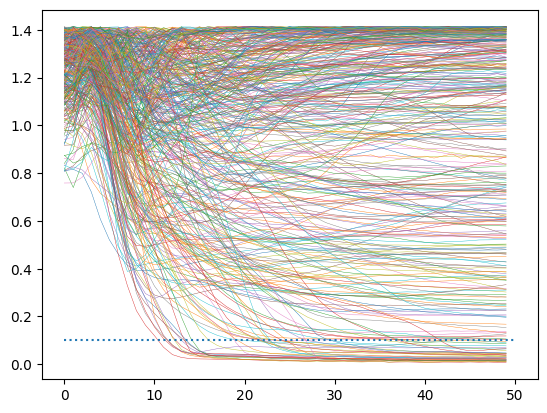

In [ ]:
plot_feature_dis(features_initial,features_train,features_final.cpu(),neuro_range=(200,600))

In [ ]:
features_initial=fi1
features_train = ft1
features_final = fl1

In [ ]:
print(feature_stats(features_initial.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
for f in features_train:
  print(feature_stats(f.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
print(feature_stats(features_final.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))

tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 1., 0., 0., 1.])
tensor([1., 0., 1., 1., 1., 0., 1.])
tensor([1., 0., 1., 1., 1., 0., 1.])
tensor([1., 0., 1., 1., 1., 0., 1.])
tensor([1., 0., 1., 1., 1., 1., 1.])
tensor([1., 0., 1., 1., 1., 0., 1.])
tensor([1., 0., 1., 1., 1., 1., 1.])
tensor([1., 0., 1., 1., 1., 1., 1.])
tensor([1., 2., 1., 1., 1., 1., 0.])
tensor([2., 1., 1., 1., 2., 1., 1.])
tensor([2., 2., 1., 1., 2., 1., 1.])
tensor([2., 2., 1., 1., 2., 1., 1.])
tensor([2., 1., 1., 1., 2., 1., 1.])
tensor([2., 1., 1., 1., 2., 1., 1.])


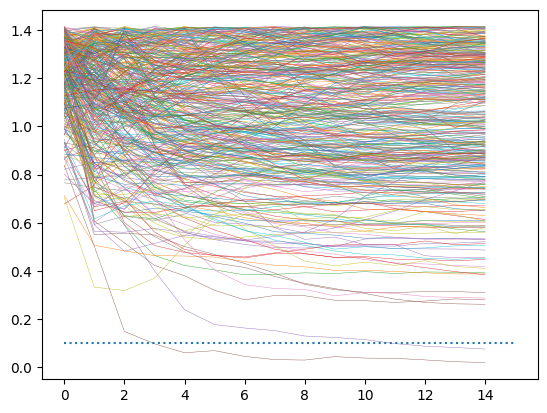

In [ ]:
plot_feature_dis(features_initial,features_train,features_final.cpu(),neuro_range=(200,600))

In [ ]:
features_initial=fi
features_train = ft
features_final = fl

In [ ]:
print(feature_stats(features_initial.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
for f in features_train:
  print(feature_stats(f.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))
print(feature_stats(features_final.cpu(),data_dim=dim_in,tree_depth=tree_depth,dim_in=dim_in,threshold=0.1))

tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 1.])
tensor([0., 0., 0., 0., 0., 0., 1.])
tensor([0., 1., 0., 1., 1., 0., 1.])
tensor([1., 1., 0., 1., 1., 1., 1.])
tensor([1., 1., 0., 1., 1., 1., 1.])
tensor([2., 1., 0., 1., 1., 1., 1.])
tensor([2., 1., 0., 1., 1., 1., 1.])
tensor([2., 1., 0., 1., 1., 1., 1.])
tensor([2., 1., 0., 1., 1., 1., 1.])
tensor([2., 1., 0., 1., 1., 1., 1.])
tensor([3., 1., 0., 1., 1., 1., 1.])
tensor([3., 1., 0., 1., 1., 1., 1.])
tensor([2., 1., 0., 1., 1., 1., 1.])
tensor([3., 1., 0., 1., 1., 1., 1.])
tensor([3., 1., 0., 1., 1., 1., 1.])
tensor([3., 1., 0., 1., 1., 1., 1.])
tensor([3., 1., 0., 1., 1., 1., 1.])
tensor([3., 1., 0., 1., 1., 1., 1.])
tensor([3., 1., 0., 1., 1., 1., 1.])


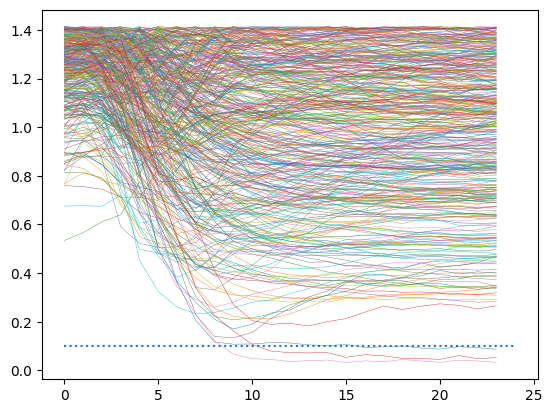

In [ ]:
plot_feature_dis(features_initial,features_train,features_final.cpu(),neuro_range=(200,600))